# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка данных

In [1]:
#Импортируем библиотеки
import pandas as pd
#EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Энкодеры
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
#Разделение и смешение выборок
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#Модели
from sklearn.linear_model import LinearRegression
#from sklearn.dummy import DummyClassifier #для случайной модели
#Метрики
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
data0 = pd.read_csv('.../geo_data_0.csv')
data1 = pd.read_csv('.../geo_data_1.csv')
data2 = pd.read_csv('.../geo_data_2.csv')
print(data0.info())
print(data1.info())
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

In [3]:
print(data0.head(3))
print(data1.head(3))
print(data2.head(3))

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
      id         f0        f1        f2     product
0  kBEdx -15.001348 -8.276000 -0.005876    3.179103
1  62mP7  14.272088 -3.475083  0.999183   26.953261
2  vyE1P   6.263187 -5.948386  5.001160  134.766305
      id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697
2  ovLUW  0.194587  0.289035 -5.586433  62.871910


Имеем следующие признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

<br>Выводы:
- каждый регион содержит 10тыс.строк о скважинах, пропуков в данных нет
- типы данных и наименования колонок в корректировке не нуждаются

### Работа с дубликатами

Проверим полные дубликаты в таблице.

In [4]:
print(data0[data0.duplicated()]['id'].count())
print(data1[data1.duplicated()]['id'].count())
print(data2[data2.duplicated()]['id'].count())

0
0
0


Полных дубликатов нет. 
<br>Проверим дубликаты по полю Id - кажется, что оно должно быть ключевым.

In [5]:
print(data0['id'].nunique())
print(data1['id'].nunique())
print(data2['id'].nunique())

99990
99996
99996


По полю id (индентификатор скважины) существуют дубликаты в таблицах.
<br>Полных дубликатов нет, значит для одной и той же скважины возможны разные признаки f0/f1/f2 или product. Для примера, найдем в нулевом регионе строки, где id скважины не уникльны.

In [6]:
data0[data0['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


**Вывод:** видим, что при одинаковых наименованиях(id), объекты содержат разные значения признаков и разные значения целевого показателя. Возможно, это некие замеры одной и той же скважины в разных состояниях или в разное время. Для моделирования это не мешает, оставим эти данные "как есть".

### Удаление лишних столбцов

Удалим из всех трех наборов данных наименования скважин, т.к. они не могут использоваться для моделирования - объем запаса нефти в скважине не может зависеть от ее названия.

In [7]:
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)
print(data0.columns)
print(data1.columns)
print(data2.columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


Лишние столбцы удалены. Далее можно проводить исследовательский анализ.

### Исследователький анализ

#### Матрица корреляций

Рассмотрим матрицу корреляций для каждого региона и построим парные графики. 

In [8]:
corr_matrix0 = data0.corr()
corr_matrix1 = data1.corr()
corr_matrix2 = data2.corr()

display(corr_matrix0.style.background_gradient(cmap='Blues', axis=None))
display(corr_matrix1.style.background_gradient(cmap='Blues', axis=None))
display(corr_matrix2.style.background_gradient(cmap='Blues', axis=None))

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


По матрице корреляций видим:
- для Data0:
    - сильной взаимной корреляции между признаками(f0,f1,f2) не обнаружено
    - наивысшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.483)
- для Data1:
    - найдена мультиколлинеарность между признаком f2 и Product (корреляция = 0,999).
    - между остальными парами признаков корреляция не превышает 0,182
- для Data2:
    - сильной взаимной корреляции между признаками(f0,f1,f2) не обнаружено
    - наивысшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.445)

<br>**Вывод:** имеющиеся в датасетах данные по трем разным региоам сильно отличаются друг от друга: между одними и теми же признаками слишком разные степени зависимости, а значит для обучения имеет смысл делать отдельную модель для каждого региона(датасета).

#### Парные графики кореляции

Построим парные графики корреляции для каждого датасета.

C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

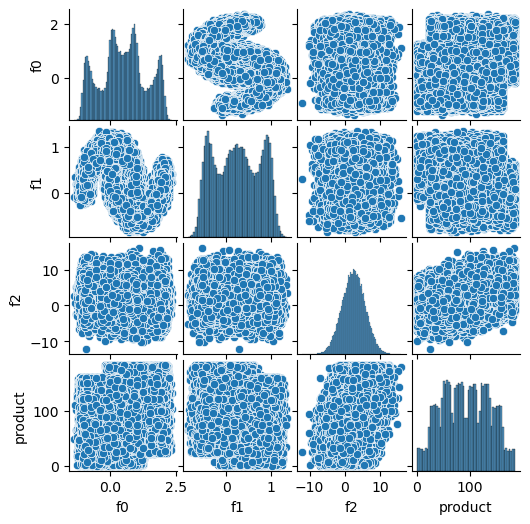

In [9]:
#plt.figure(figsize=(10,10))
sns.pairplot(data0)
plt.gcf().set_size_inches(5, 5)
plt.show()

По данным графикам видим: 
- несмотря на то, что по показателю корреляции f0иf1 значение 0,44 (средний уровень), на графике мы видим, что однозначно есть некая зависимость - график напоминает спираль или две противоположно направленные параболы.
- видна положительная корреляция между f2 и Product, но с большим размахом точек.
- по f0 vs Product и f1 vs Product тоже интересные графики: напоминают два наложенных прямоугольника с довольно четкими границами: 

<br>Можно осторожно предпложить, что внутри датасета как-будто выделяются две подвыборки с разным поведением признаков f0 и f1 между собой и с вот такими примерными границами:
- 1) со значением f0 [-1:1], f1 [-0.2:1.5] - Product [0:175] 
- 2) со значением f0 [0:2], f1 [-1:0,75] - Product [25:200] 

<br>Но это лишь предположение, реальная взаимосвязь может не соответствовать такому положению дел.

C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

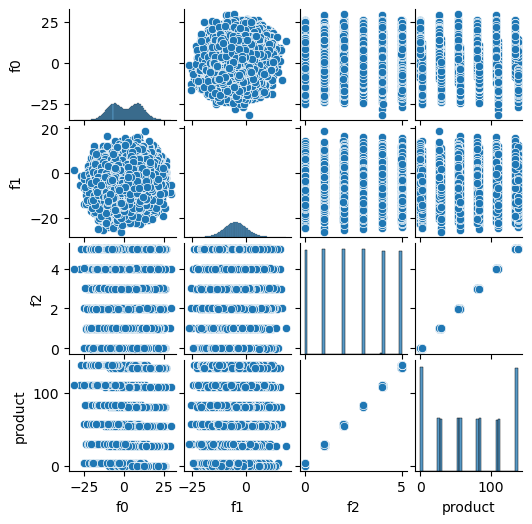

In [10]:
sns.pairplot(data1)
plt.gcf().set_size_inches(5, 5)
plt.show()

Данные по региону 1:
- видим, что все признаки f2 и Product имеют очень небольшое ограниченное количество уникальных значений, поэтому графики превратились в линии
- есть четкая корреляция между f2 и Product (по матрице мы видели, что она почти 100%)
- корреляции между f0 и f1 не наблюдается, при этом значения разбросаны равномерно от-20 до 20.

C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

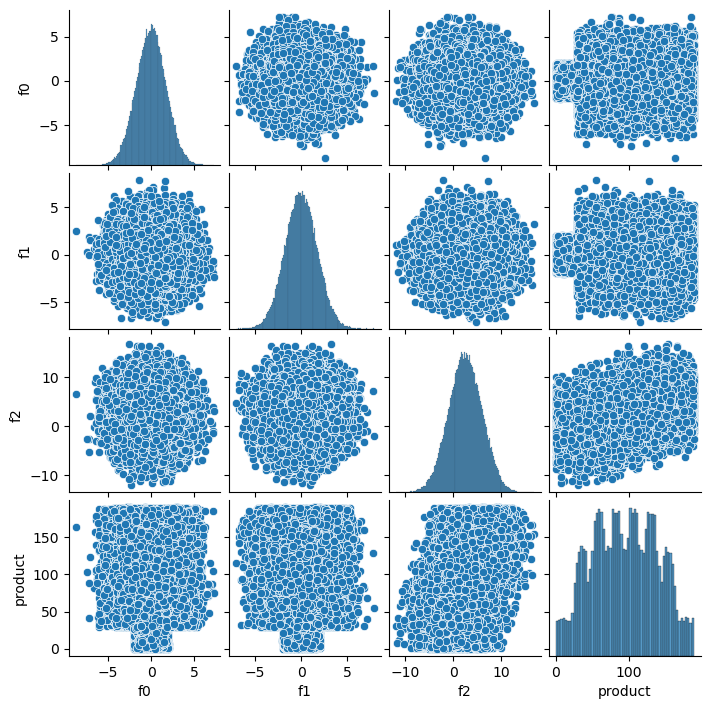

In [11]:
sns.pairplot(data2)
plt.gcf().set_size_inches(7, 7)
plt.show()

Данные по региону 2:
- нет корреляции между признаками f0,f1,f2
- f0,f1,f2 распределены симметрично и колоколообразно
- есть небольшая корреляция между f2 и Product с большим разбросом точек

**Общий вывод по анализу:**
<br> Мы видим, что действительно у нас три датасета с идентичной структурой данных (набор признаков и таргет), но абсолютно разным содержимым. В каждом датасете прослеживаются свои собственные зависимости и области определения признаков. 

- для Data0:
    - сильной взаимной корреляции между признаками(f0,f1,f2) не обнаружено
    - наивысшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.483)
    - несмотря на то, что по показателю корреляции f0иf1 значение 0,44 (средний уровень), на графике мы видим, что однозначно есть некая зависимость - график напоминает спираль или две противоположно направленные параболы.
    - видна положительная корреляция между f2 и Product, но с большим размахом точек.
    - по f0 vs Product и f1 vs Product тоже интересные графики: напоминают два наложенных прямоугольника с довольно четкими границами. 
    - Можно осторожно предпложить, что внутри датасета как-будто выделяются две подвыборки с разным поведением признаков f0 и f1 между собой и с вот такими примерными границами:
        - 1) со значением f0 [-1:1], f1 [-0.2:1.5] - Product [0:175] 
        - 2) со значением f0 [0:2], f1 [-1:0,75] - Product [25:200] 

- для Data1:
    - найдена мультиколлинеарность между признаком f2 и Product (корреляция = 0,999).
    - между остальными парами признаков корреляция не превышает 0,182
    - признаки f2 и Product имеют очень небольшое ограниченное количество уникальных значений
    - корреляции между f0 и f1 не наблюдается, при этом значения разбросаны равномерно от-20 до 20.

- для Data2:
    - нет корреляции между признаками(f0,f1,f2) 
    - небольшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.445) (с большим разбросом точек)
    - f0,f1,f2 распределены симметрично и колоколообразно
   
<br>Таким образом, из-за отличий в зависимостях внутри каждого датасета, на всех трех датасетах мы получим абсолютно разные модели. Попробуем на каждом наборе обучить линейную регрессию.

## Обучение и проверка модели

Так как процесс создания, обучения и анализа модели необходимо проделать трижды по одному и тому же сценарию, то разработаем функцию, которая будет принимать на вход датасет и выполнять:
- разделять выборку на валидационную и тестовую
- масштабирует количественные признаки
- создаст и обучит модель
- посчитает средний запас сырья, RMSE модели
- сохранит необходимые данные (таргет, предсказания и т.д.) для дальнейшего использования

<br>Но для начала подготовим структуры (датафреймы) для хранения промежуточных данных, которые нам могут понадобится в дальнейшем:
- таблица предсказаний против таргетных значений (predictions_and_target)

In [12]:
predictions_and_target = pd.DataFrame(columns=['dataset', 'index_id','prediction','target'])
predictions_and_target

,dataset,index_id,prediction,target


In [13]:
def learn_check_model(data, data_name):
    #Определим фичи и таргет
    features = data.drop(['product'], axis=1)# признак
    target = data['product'] # целевой признак
    #Разобьем выборку на обучающую и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345) # отделим 25% данных для валидационной выборки
    #Масштабирование признаков
    pd.options.mode.chained_assignment = None
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    #Создадим и обучим модель
    model = LinearRegression()# инициализируем модель LinearRegression
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    #Сохраним предсказания в predictions_and_target и добавим значения таргета    
    predictions_valid = pd.DataFrame(predictions_valid,index=features_valid.index)
    pt = predictions_valid.merge(target_valid,left_index=True, right_index=True)
    pt['index_id'] = predictions_valid.index
    pt['dataset'] = data_name
    pt.columns = ['prediction','target','index_id','dataset']
    pt = pt[['dataset','index_id','prediction','target']] # переопределим порядок столбцов для красоты    
    global predictions_and_target
    predictions_and_target = predictions_and_target[predictions_and_target['dataset'] != data_name] #удалим старые расчеты по этому датасету
    predictions_and_target = pd.concat([predictions_and_target,pt]) #добавим данные в итоговую таблицу
    #Посчитаем метрики
    rmse = (mean_squared_error(pt['target'],pt['prediction']))**0.5 # посчитаем значение метрики RMSE на валидационной выборке
    mean_product = pt['prediction'].mean()
    print("RMSE модели линейной регрессии на валидационной выборке:", round(rmse,2))
    print("Средний запас сырья на валидационной выборке (по предсказаниям):", round(mean_product,2))


In [14]:
learn_check_model(data0, 'data0')

RMSE модели линейной регрессии на валидационной выборке: 37.58
Средний запас сырья на валидационной выборке (по предсказаниям): 92.59


C:\Users\PC\AppData\Local\Temp\ipykernel_22340\1631870807.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_and_target = pd.concat([predictions_and_target,pt]) #добавим данные в итоговую таблицу


In [15]:
learn_check_model(data1, 'data1')

RMSE модели линейной регрессии на валидационной выборке: 0.89
Средний запас сырья на валидационной выборке (по предсказаниям): 68.73


In [16]:
learn_check_model(data2, 'data2')

RMSE модели линейной регрессии на валидационной выборке: 40.03
Средний запас сырья на валидационной выборке (по предсказаниям): 94.97


Проверим, что таблица predictions_and_target заполнилась.

In [17]:
predictions_and_target.groupby(by='dataset').head(3)

,dataset,index_id,prediction,target
71751,data0,71751,95.894952,10.038645
80493,data0,80493,77.572583,114.551489
2655,data0,2655,77.892640,132.603635
71751,data1,71751,82.663314,80.859783
80493,data1,80493,54.431786,53.906522
2655,data1,2655,29.748760,30.132364
71751,data2,71751,93.599633,61.212375
80493,data2,80493,75.105159,41.850118
2655,data2,2655,90.066809,57.776581


**Вывод:** по полученным данным видим, что по предсказаниям объем сырья в каждом регионе не превышает 100единиц.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

Бюджет на разработку региона (BUDGET) составляет 10 млрд (10^10) и он рассчитан на 200 точек (N_POINTS). 
<br>Значит, на разработку каждой точки должно в среднем приходиться 10^10 / 200 = 50млн.руб. (one_point_budget)
<br> Чтобы проект был прибыльным, доход с каждой точки должен быть больше 50млн. Т.к. каждая единица продукта стоит 450тыс, то в средний запас нефти в точке должен быть не менее 5*10^7/450000 = 111 единиц продукта

In [18]:
BUDGET = 10_000_000_000
N_POINTS = 200
PRODUCT_PRICE = 450_000

one_point_budget = BUDGET/N_POINTS
one_point_product_wish = one_point_budget / PRODUCT_PRICE
print('Cредний запас нефти в точках для разработки должен быть не менее:',round(one_point_product_wish,2))

Cредний запас нефти в точках для разработки должен быть не менее: 111.11


В каждой скважине должно быть в среднем 111 единиц.
<br> По показателям выше мы видели, что в каждом регионе средний показатель не превышает 100единиц. Неутешительно, однако, нам нужны только 200 лучших точек, а их показатели могут сильно отличаться от среднего по всему региону.

Разработаем функцию, которая считает прибыль по выбранным точкам.
<br>На вход ей подаются массивы по прогнозным и реальным объемам нефти. Из них она выбирает несколько (count) наиболее удачных по прогнозу точек, которые должны выдать максимальное количество нефти. 
Далее по точкам считаем реальный объем выданной нефти и полученную от этого прибыль.
- target - релаьный объем нефти
- predictions - пронозируемый объем
- count - количество точек для выбора из всего массива

In [19]:
def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return PRODUCT_PRICE * selected.sum() - BUDGET

## Расчёт прибыли и рисков 

Для георазведки используются всегда 500 точек, из которых затем для разработки выбираются 200 наиболее удачных по прогнозным значениям выдаваемой нефти.
<br>Разработаем функцию, которая бутстрепом переберет подвыборки по 500 точек и по лучшим 200 из них посчитает полученную прибыль. Из 1000 подвыборок, перебранных бутстрепом, получим распределение прибыли.

In [20]:
def bootstrap_revenue(data_name, sample_size, select_size):
    state = np.random.RandomState(12345)   
    values = []
    for i in range(1000):
        datasample = predictions_and_target[predictions_and_target['dataset']==data_name].sample(sample_size, replace=True, random_state=state) 
        target_subsample = datasample['target']
        predict_subsample = datasample['prediction']
        values.append(revenue(target_subsample,predict_subsample,select_size)) 
    values = pd.Series(values)
    values.hist(bins=100)
    upper = values.quantile(0.975)/10**6 # верхний порог 95%-интервала (переведено в млн)
    lower = values.quantile(0.025)/10**6 # нижний порог 95%-интервала (переведено в млн)   
    mu = values.mean()
    print('95% интервал: от',round(lower,2),'млн. до',round(upper,2),'млн.')
    print('Средняя прибыль:',round(mu/10**6,2),'млн.')
#     print('Риск убытков:',round(distr_revenue.cdf(BUDGET)*100,2),'%')
    print('Риск убытков:',(values < 0).mean() * 100, '%')


95% интервал: от -102.09 млн. до 947.98 млн.
Средняя прибыль: 425.94 млн.
Риск убытков: 6.0 %


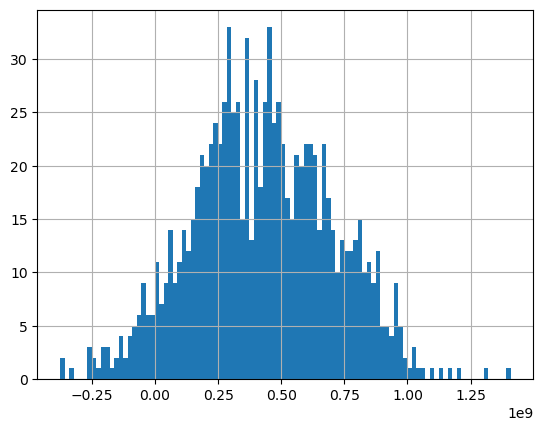

In [21]:
bootstrap_revenue('data0',500,200)

95% интервал: от 68.87 млн. до 931.55 млн.
Средняя прибыль: 515.22 млн.
Риск убытков: 1.0 %


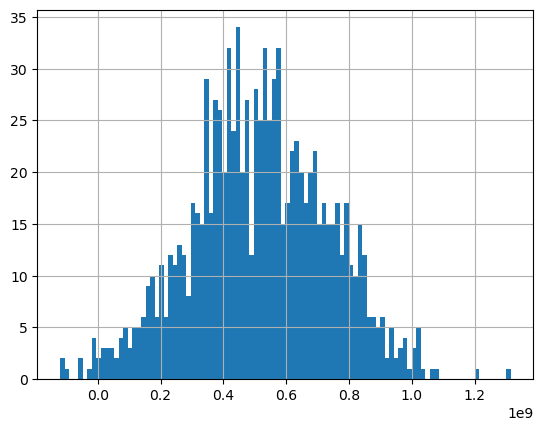

In [22]:
bootstrap_revenue('data1',500,200)

95% интервал: от -128.88 млн. до 969.71 млн.
Средняя прибыль: 435.01 млн.
Риск убытков: 6.4 %


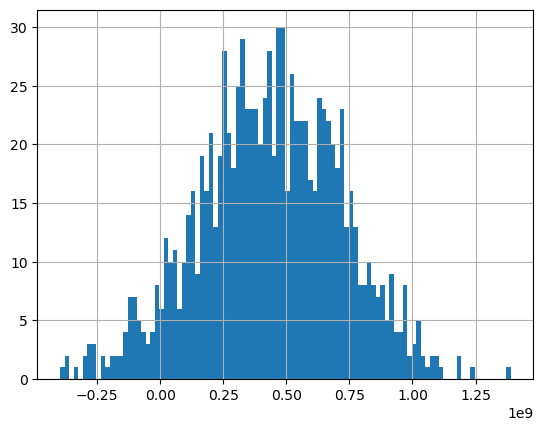

In [23]:
bootstrap_revenue('data2',500,200)

Судя по полученным данным, для разработки подходит только второй из трех датасетов (geo_data_1).
Только по данному региону риск убытков составляет 1 % (<2.5%), по двум остальным регионам риск убытков выше - 6%.
Стоит однако помнить, что наилучшие точки мы выбирали по предсказаниям модели. Соответственно, есть также риск, что полученное распределение прибыли может быть занижено или завышено относительного истинного распределения прибыли.

## Общий вывод по исследованию

<br>Перед началом исследования стояла цель: выбрать регион для бурения скважины. Для этого необходимо было проанализировать имеющиеся данные по георазведке и оценить прибыль, которая будет получена в каждом регионе от 200новых скважин, при условии, что бюджет составляет 10млрд.рублей.
<br>Были предоставлены данные о разведке по трем регионам.

<br>**В ходе подготовки данных было сделано:**
- данные по трем регионам были загружены в отельные таблицы для анализа
- были проверены пропуски в данных, дубликаты
- были удалены лишние столбцы (id скважины)

<br>**Первичный исследовательский анализ показал:**
<br> Анализ показал, что во всех трех датасетах находят разные по струкруте зависимостей данные. Поэтому для каждого датасета необходимо обучать собственную модель. В качестве модели для всех трех датасетов была использована линейная регрессия.
<br> По данным в датасетах были сделаны следующие выводы:
- для Data0:
    - сильной взаимной корреляции между признаками(f0,f1,f2) не обнаружено
    - наивысшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.483)
    - несмотря на то, что по показателю корреляции f0иf1 значение 0,44 (средний уровень), на графике мы видим, что однозначно есть некая зависимость - график напоминает спираль или две противоположно направленные параболы.
    - видна положительная корреляция между f2 и Product, но с большим размахом точек.
    - по f0 vs Product и f1 vs Product тоже интересные графики: напоминают два наложенных прямоугольника с довольно четкими границами. 
    - Можно осторожно предпложить, что внутри датасета как-будто выделяются две подвыборки с разным поведением признаков f0 и f1 между собой и с вот такими примерными границами:
        - 1) со значением f0 [-1:1], f1 [-0.2:1.5] - Product [0:175] 
        - 2) со значением f0 [0:2], f1 [-1:0,75] - Product [25:200] 

- для Data1:
    - найдена мультиколлинеарность между признаком f2 и Product (корреляция = 0,999).
    - между остальными парами признаков корреляция не превышает 0,182
    - признаки f2 и Product имеют очень небольшое ограниченное количество уникальных значений
    - корреляции между f0 и f1 не наблюдается, при этом значения разбросаны равномерно от-20 до 20.

- для Data2:
    - нет корреляции между признаками(f0,f1,f2) 
    - небольшая корреляция с целевым признаком (Product) обнаружена у признака f2 (0.445) (с большим разбросом точек)
    - f0,f1,f2 распределены симметрично и колоколообразно


<br>**В ходе обучения модели были сделано:**
- разработана общая функция, позволяющая подвать на вход один из трех датасетов и обучать модель по каждому из них
- данные прогнозов в ходе обучения модели сохраняются в отдельную таблицу для дальнейшего анализа
- для каждого из датасетов была обучена модель линейной регрессии и получены следущие показатели:
- Для Data0:
    - RMSE модели линейной регрессии на валидационной выборке: 37.58
    - Средний запас сырья на валидационной выборке (по предсказаниям): 92.59
- Для Data1:
    - RMSE модели линейной регрессии на валидационной выборке: 0.89
    - Средний запас сырья на валидационной выборке (по предсказаниям): 68.73
- Для Data2:
    - RMSE модели линейной регрессии на валидационной выборке: 40.03
    - Средний запас сырья на валидационной выборке (по предсказаниям): 94.97 

<br>Судя по среднему запасу сырья, наиболее хорошим кажется регион Data2. Однако, в ходе подготовки к расчету прибыли было выявлено, что для безубыточного проекта нефтяные скважины должны содержать в среднем 111 единиц нефти. Неутешительно, но, нам нужны только 200 лучших точек из всего региона, а их показатели могут сильно отличаться от среднего по всему региону.

<br>**В ходе подготовки к расчету прибыли было сделано:**
- рассчитано среднее значение объема нефти, необходимое для безубыточного проекта (111 единиц).
- была разработана функция, которая подсчитывает реально получаемую прибыль в зависимости от выбора точек исходя из спрогнозированных значений 

<br>**В ходе расчета прибыли и рисков:**
<br>В ходе расчета прибыли и рисков было выявлено, что наиболее удачным регионом для разработки является регион Data1, так как только по этому региону риск убытков менее 2,5% (а точнее равен 0,93%). По двум другим регионам риск убытка 6,2%. Стоит однако помнить, что наилучшие точки мы выбирали по предсказаниям модели. Соответственно, есть также риск, что полученное распределение прибыли может быть занижено или завышено относительного истинного распределения прибыли в связи с недостаточным качеством обученной модели.

